In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = Path(PROJECT_PATH, 'raw')

print('Project path: ', PROJECT_PATH)
print('Data path: ', DATA_PATH)

Project path:  /Users/taehyun/project/side-projects/data/dunnhumby
Data path:  /Users/taehyun/project/side-projects/data/dunnhumby/raw


# Marketing Exposure EDA (causal_data)

## Table of Contents

5. [Marketing Exposure Analysis (causal_data)](#5.-Marketing-Exposure-Analysis)
   - 5.1 Data Loading & Overview
   - 5.2 Display & Mailer Distributions
   - 5.3 Exposure Rate by Category
   - 5.4 Data Quality Check (Outlier Departments)
   - 5.5 Exposure-Sales Relationship
   - 5.6 Combined Effects (Display × Mailer)

## 5.1 Data Loading & Overview

In [2]:
# Load causal_data (large file ~664MB)
print("Loading causal_data...")
df_causal = pd.read_csv(DATA_PATH / 'causal_data.csv')
print(f"Loaded: {len(df_causal):,} rows")

# Load transaction_data
print("\nLoading transaction_data...")
df_trans = pd.read_csv(DATA_PATH / 'transaction_data.csv')
print(f"Loaded: {len(df_trans):,} rows")

# Load product
print("\nLoading product...")
df_product = pd.read_csv(DATA_PATH / 'product.csv')
print(f"Loaded: {len(df_product):,} rows")

Loading causal_data...
Loaded: 36,786,524 rows

Loading transaction_data...
Loaded: 2,595,732 rows

Loading product...
Loaded: 92,353 rows


In [3]:
# Basic statistics
print("="*60)
print("CAUSAL DATA OVERVIEW")
print("="*60)
print(f"\nDimensions: {len(df_causal):,} rows, {len(df_causal.columns)} columns")
print(f"Columns: {df_causal.columns.tolist()}")
print(f"\nUnique counts:")
print(f"  Products: {df_causal['PRODUCT_ID'].nunique():,}")
print(f"  Stores: {df_causal['STORE_ID'].nunique():,}")
print(f"  Weeks: {df_causal['WEEK_NO'].nunique()} (range: {df_causal['WEEK_NO'].min()}-{df_causal['WEEK_NO'].max()})")

print(f"\nDisplay values: {sorted(df_causal['display'].unique())}")
print(f"Mailer values: {sorted(df_causal['mailer'].unique())}")

CAUSAL DATA OVERVIEW

Dimensions: 36,786,524 rows, 5 columns
Columns: ['PRODUCT_ID', 'STORE_ID', 'WEEK_NO', 'display', 'mailer']

Unique counts:
  Products: 68,377
  Stores: 115
  Weeks: 93 (range: 9-101)

Display values: ['0', '1', '2', '3', '4', '5', '6', '7', '9', 'A']
Mailer values: ['0', 'A', 'C', 'D', 'F', 'H', 'J', 'L', 'P', 'X', 'Z']


In [4]:
# Define binary exposure indicators
df_causal = df_causal.assign(
    has_display=lambda x: (x['display'] != '0').astype(int),
    has_mailer=lambda x: (x['mailer'] != '0').astype(int)
)

print("="*60)
print("EXPOSURE RATES (within causal_data)")
print("="*60)
print(f"\nDisplay exposure: {df_causal['has_display'].mean()*100:.1f}%")
print(f"Mailer exposure: {df_causal['has_mailer'].mean()*100:.1f}%")

# Note: causal_data only contains records with at least one exposure
# (display OR mailer), so "any exposure" = 100% within this dataset
no_exposure_in_causal = ((df_causal['display'] == '0') & (df_causal['mailer'] == '0')).sum()
print(f"\nNote: Records with no exposure (display=0 AND mailer=0): {no_exposure_in_causal:,}")
print("→ causal_data only contains product-store-weeks with some marketing exposure")

EXPOSURE RATES (within causal_data)

Display exposure: 42.8%
Mailer exposure: 68.6%

Note: Records with no exposure (display=0 AND mailer=0): 0
→ causal_data only contains product-store-weeks with some marketing exposure


## 5.2 Display & Mailer Distributions

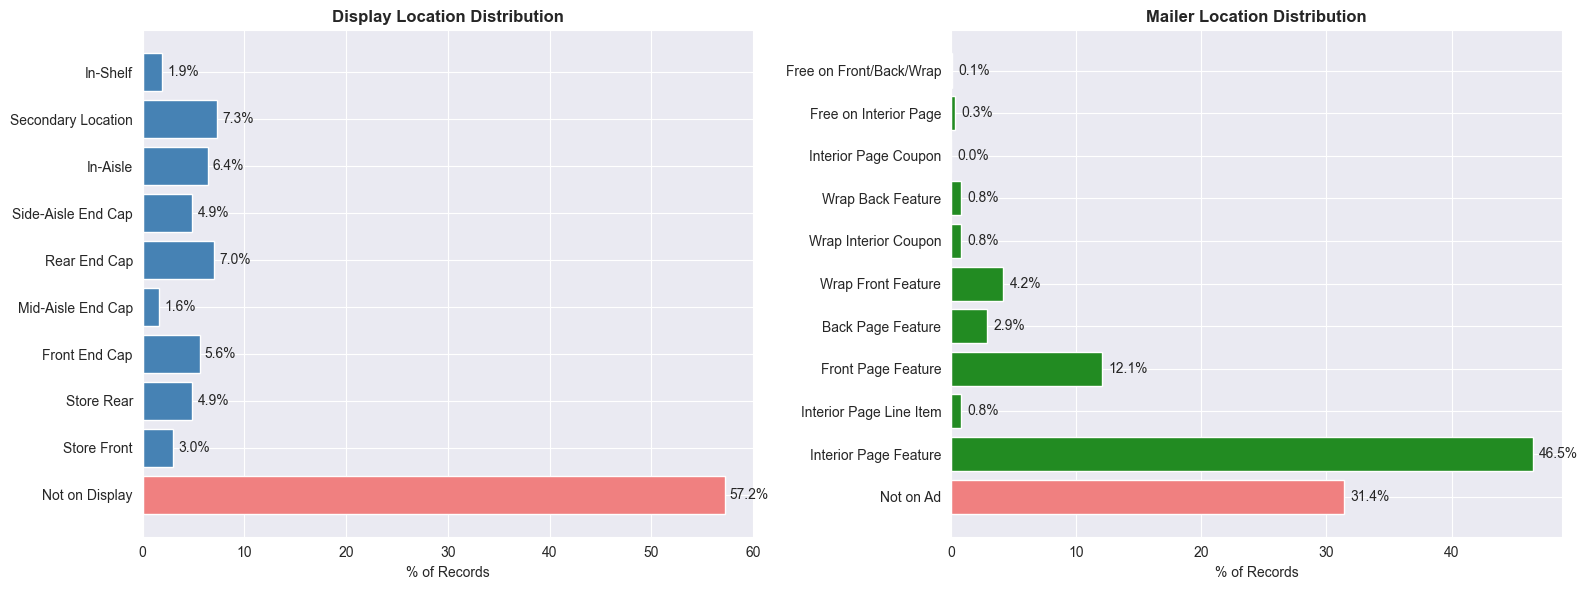

In [14]:
# Display and Mailer code mappings
display_labels = {
    '0': 'Not on Display',
    '1': 'Store Front',
    '2': 'Store Rear',
    '3': 'Front End Cap',
    '4': 'Mid-Aisle End Cap',
    '5': 'Rear End Cap',
    '6': 'Side-Aisle End Cap',
    '7': 'In-Aisle',
    '9': 'Secondary Location',
    'A': 'In-Shelf'
}

mailer_labels = {
    '0': 'Not on Ad',
    'A': 'Interior Page Feature',
    'C': 'Interior Page Line Item',
    'D': 'Front Page Feature',
    'F': 'Back Page Feature',
    'H': 'Wrap Front Feature',
    'J': 'Wrap Interior Coupon',
    'L': 'Wrap Back Feature',
    'P': 'Interior Page Coupon',
    'X': 'Free on Interior Page',
    'Z': 'Free on Front/Back/Wrap'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Display distribution
display_counts = df_causal['display'].value_counts().sort_index()
display_pct = (display_counts / len(df_causal) * 100).round(1)
colors = ['lightcoral' if x == '0' else 'steelblue' for x in display_counts.index]
bars = axes[0].barh([display_labels.get(x, x) for x in display_counts.index], display_pct, color=colors)
axes[0].set_xlabel('% of Records')
axes[0].set_title('Display Location Distribution', fontsize=12, fontweight='bold')
for bar, pct in zip(bars, display_pct):
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{pct}%', va='center')

# 2) Mailer distribution
mailer_counts = df_causal['mailer'].value_counts().sort_index()
mailer_pct = (mailer_counts / len(df_causal) * 100).round(1)
colors = ['lightcoral' if x == '0' else 'forestgreen' for x in mailer_counts.index]
bars = axes[1].barh([mailer_labels.get(x, x) for x in mailer_counts.index], mailer_pct, color=colors)
axes[1].set_xlabel('% of Records')
axes[1].set_title('Mailer Location Distribution', fontsize=12, fontweight='bold')
for bar, pct in zip(bars, mailer_pct):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{pct}%', va='center')

plt.tight_layout()
plt.show()

## 5.3 Exposure Rate by Category

In [15]:
# Join causal_data with product to get department
df_causal_product = df_causal.merge(
    df_product[['PRODUCT_ID', 'DEPARTMENT', 'BRAND']],
    on='PRODUCT_ID',
    how='left'
)

# Exposure rate by department
exposure_by_dept = df_causal_product.groupby('DEPARTMENT').agg(**{
    'display_rate': ('has_display', 'mean'),
    'mailer_rate': ('has_mailer', 'mean'),
    'n_records': ('PRODUCT_ID', 'count'),
    'n_products': ('PRODUCT_ID', 'nunique')
}).sort_values('n_records', ascending=False)

print("="*60)
print("EXPOSURE RATE BY DEPARTMENT")
print("="*60)
print(exposure_by_dept.head(15).to_markdown())

EXPOSURE RATE BY DEPARTMENT
| DEPARTMENT      |   display_rate |   mailer_rate |        n_records |   n_products |
|:----------------|---------------:|--------------:|-----------------:|-------------:|
| GROCERY         |      0.427061  |      0.707733 |      2.43115e+07 |        32287 |
| DRUG GM         |      0.549335  |      0.528873 |      5.61449e+06 |        21981 |
| MEAT-PCKGD      |      0.482865  |      0.694653 |      2.0239e+06  |         1942 |
| PRODUCE         |      0.207889  |      0.80621  | 916849           |         2110 |
| MEAT            |      0.0134268 |      0.988845 | 844429           |          880 |
| NUTRITION       |      0.7159    |      0.3312   | 816092           |         2576 |
| DELI            |      0.143561  |      0.86177  | 769574           |         1186 |
| COSMETICS       |      0.0831675 |      0.922539 | 507975           |         2460 |
| SEAFOOD-PCKGD   |      0.503617  |      0.617177 | 495069           |          509 |
| PASTRY       

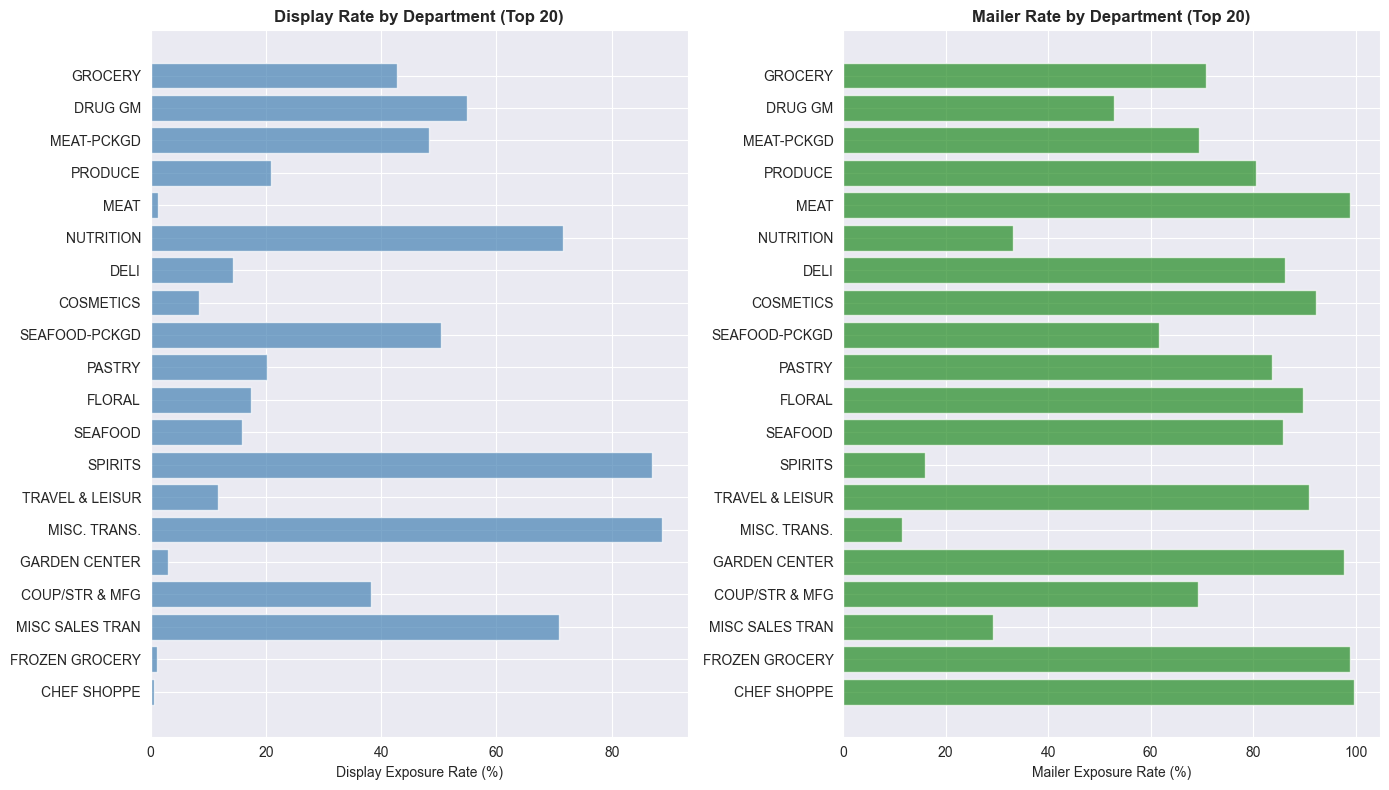

In [16]:
# Top 20 departments by record count
top_depts = exposure_by_dept.head(20)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# 1) Display rate by department
y_pos = range(len(top_depts))
axes[0].barh(y_pos, top_depts['display_rate'] * 100, color='steelblue', alpha=0.7)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(top_depts.index)
axes[0].set_xlabel('Display Exposure Rate (%)')
axes[0].set_title('Display Rate by Department (Top 20)', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# 2) Mailer rate by department
axes[1].barh(y_pos, top_depts['mailer_rate'] * 100, color='forestgreen', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(top_depts.index)
axes[1].set_xlabel('Mailer Exposure Rate (%)')
axes[1].set_title('Mailer Rate by Department (Top 20)', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

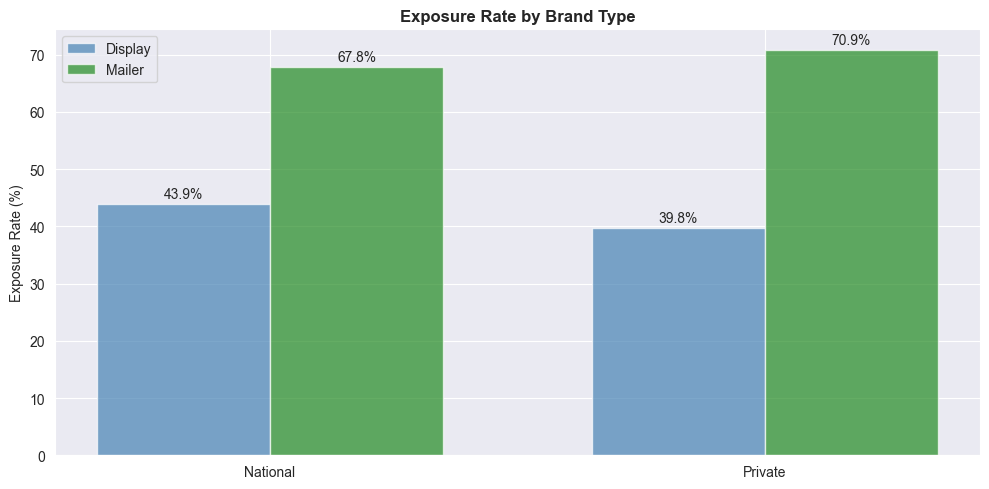

EXPOSURE RATE BY BRAND
| BRAND    |   display_rate |   mailer_rate |   n_records |
|:---------|---------------:|--------------:|------------:|
| National |       0.438994 |      0.678489 | 2.70811e+07 |
| Private  |       0.397648 |      0.708687 | 9.70543e+06 |


In [17]:
# Exposure rate by brand (National vs Private)
exposure_by_brand = df_causal_product.groupby('BRAND').agg(**{
    'display_rate': ('has_display', 'mean'),
    'mailer_rate': ('has_mailer', 'mean'),
    'n_records': ('PRODUCT_ID', 'count')
})

fig, ax = plt.subplots(figsize=(10, 5))

x = range(len(exposure_by_brand))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], exposure_by_brand['display_rate'] * 100, 
               width, label='Display', color='steelblue', alpha=0.7)
bars2 = ax.bar([i + width/2 for i in x], exposure_by_brand['mailer_rate'] * 100, 
               width, label='Mailer', color='forestgreen', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(exposure_by_brand.index)
ax.set_ylabel('Exposure Rate (%)')
ax.set_title('Exposure Rate by Brand Type', fontsize=12, fontweight='bold')
ax.legend()

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{bar.get_height():.1f}%', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{bar.get_height():.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("="*60)
print("EXPOSURE RATE BY BRAND")
print("="*60)
print(exposure_by_brand.to_markdown())

## 5.4 Data Quality Check (Outlier Departments)

In [45]:
# Check department-level quantity statistics to identify outliers
df_trans_dept = df_trans.merge(df_product[['PRODUCT_ID', 'DEPARTMENT']], on='PRODUCT_ID', how='left')

# Department-level stats
dept_stats = df_trans_dept.groupby('DEPARTMENT').agg(**{
    'mean_qty': ('QUANTITY', 'mean'),
    'median_qty': ('QUANTITY', 'median'),
    'max_qty': ('QUANTITY', 'max'),
    'n_transactions': ('BASKET_ID', 'count'),
    'n_products': ('PRODUCT_ID', 'nunique')
}).sort_values('mean_qty', ascending=False)

# Check causal_data coverage by department
products_in_causal = set(df_causal['PRODUCT_ID'].unique())
dept_product_list = df_product.groupby('DEPARTMENT')['PRODUCT_ID'].apply(list)
dept_causal_coverage = {
    dept: sum(1 for p in products if p in products_in_causal) / len(products) * 100 
    for dept, products in dept_product_list.items() if products
}
dept_stats['causal_coverage_%'] = dept_stats.index.map(dept_causal_coverage)

print("="*80)
print("DEPARTMENT STATISTICS (sorted by mean_qty) - Identify Outliers")
print("="*80)
print(dept_stats.head(20).to_string())

# Highlight outliers
print("\n" + "="*80)
print("OUTLIER DEPARTMENTS (mean_qty > 100)")
print("="*80)
outlier_depts = dept_stats[dept_stats['mean_qty'] > 100]
print(outlier_depts.to_string())
print(f"\n→ These departments have abnormally high quantities and should be excluded from analysis")

DEPARTMENT STATISTICS (sorted by mean_qty) - Identify Outliers
                     mean_qty  median_qty  max_qty  n_transactions  n_products  causal_coverage_%
DEPARTMENT                                                                                       
KIOSK-GAS        10030.141303     10005.0    89638           22059          16           0.000000
MISC SALES TRAN   5963.778512         2.0    85055            6050          88          46.590909
VIDEO RENTAL         2.200000         2.0        4               5           3           0.000000
GARDEN CENTER        1.855556         1.0       16             720         128          46.875000
CHARITABLE CONT      1.500000         1.5        2               2           2         100.000000
MISC. TRANS.         1.497235         1.0       30            2351         490          27.755102
DAIRY DELI           1.452830         1.0        4              53           3          66.666667
POSTAL CENTER        1.400000         1.0        4     

## 5.5 Exposure-Sales Relationship

In [46]:
# Exclude outlier departments (abnormally high quantities)
EXCLUDE_DEPTS = ['KIOSK-GAS', 'MISC SALES TRAN']

retail_products = df_product[~df_product['DEPARTMENT'].isin(EXCLUDE_DEPTS)]['PRODUCT_ID']
df_trans_filtered = df_trans[df_trans['PRODUCT_ID'].isin(retail_products)]

print(f"Excluded departments: {EXCLUDE_DEPTS}")
print(f"Transactions before filter: {len(df_trans):,}")
print(f"Transactions after filter: {len(df_trans_filtered):,} ({len(df_trans_filtered)/len(df_trans)*100:.1f}%)")

# Aggregate transactions to product-store-week level
print("\nAggregating transaction data...")
sales_agg = df_trans_filtered.groupby(['PRODUCT_ID', 'STORE_ID', 'WEEK_NO']).agg(**{
    'total_sales': ('SALES_VALUE', 'sum'),
    'total_quantity': ('QUANTITY', 'sum'),
    'n_transactions': ('BASKET_ID', 'count')
}).reset_index()

print(f"Aggregated: {len(sales_agg):,} product-store-week combinations")

Excluded departments: ['KIOSK-GAS', 'MISC SALES TRAN']
Transactions before filter: 2,595,732
Transactions after filter: 2,567,623 (98.9%)

Aggregating transaction data...
Aggregated: 2,361,128 product-store-week combinations


In [47]:
# Join with exposure data
print("Joining with exposure data...")
exposure_sales = sales_agg.merge(
    df_causal[['PRODUCT_ID', 'STORE_ID', 'WEEK_NO', 'has_display', 'has_mailer']],
    on=['PRODUCT_ID', 'STORE_ID', 'WEEK_NO'],
    how='left'
)

# Fill NaN (products not in causal_data) with 0
exposure_sales['has_display'] = exposure_sales['has_display'].fillna(0).astype(int)
exposure_sales['has_mailer'] = exposure_sales['has_mailer'].fillna(0).astype(int)

print(f"Joined: {len(exposure_sales):,} records")
print(f"With display: {exposure_sales['has_display'].sum():,} ({exposure_sales['has_display'].mean()*100:.1f}%)")
print(f"With mailer: {exposure_sales['has_mailer'].sum():,} ({exposure_sales['has_mailer'].mean()*100:.1f}%)")

Joining with exposure data...
Joined: 2,361,743 records
With display: 237,049 (10.0%)
With mailer: 350,801 (14.9%)


In [48]:
# Verify: Any exposure rate after joining with transactions
any_exposure = ((exposure_sales['has_display'] == 1) | (exposure_sales['has_mailer'] == 1)).mean() * 100
no_exposure = ((exposure_sales['has_display'] == 0) & (exposure_sales['has_mailer'] == 0)).mean() * 100

print("="*60)
print("EXPOSURE COVERAGE CHECK (after join with transactions)")
print("="*60)
print(f"\nAny exposure (display OR mailer): {any_exposure:.1f}%")
print(f"No exposure (neither): {no_exposure:.1f}%")
print(f"\n→ causal_data only records product-store-weeks WITH some exposure")
print(f"→ {no_exposure:.1f}% of transactions have no matching exposure record")

EXPOSURE COVERAGE CHECK (after join with transactions)

Any exposure (display OR mailer): 20.5%
No exposure (neither): 79.5%

→ causal_data only records product-store-weeks WITH some exposure
→ 79.5% of transactions have no matching exposure record


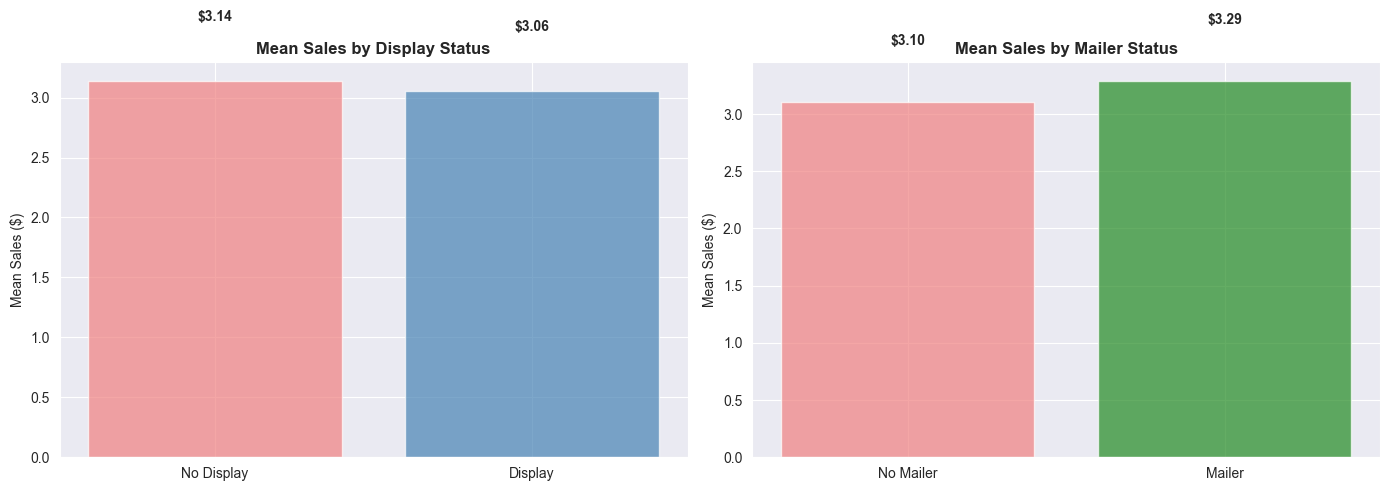

SALES BY EXPOSURE STATUS

Display effect:
  No display: $3.14
  With display: $3.06
  Difference: $-0.08 (+-2.7%)

Mailer effect:
  No mailer: $3.10
  With mailer: $3.29
  Difference: $0.19 (+6.0%)


In [49]:
# Compare sales by exposure status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Sales by display status
display_sales = exposure_sales.groupby('has_display')['total_sales'].mean()
axes[0].bar(['No Display', 'Display'], display_sales.values, color=['lightcoral', 'steelblue'], alpha=0.7)
axes[0].set_ylabel('Mean Sales ($)')
axes[0].set_title('Mean Sales by Display Status', fontsize=12, fontweight='bold')
for i, v in enumerate(display_sales.values):
    axes[0].text(i, v + 0.5, f'${v:.2f}', ha='center', fontweight='bold')

# 2) Sales by mailer status
mailer_sales = exposure_sales.groupby('has_mailer')['total_sales'].mean()
axes[1].bar(['No Mailer', 'Mailer'], mailer_sales.values, color=['lightcoral', 'forestgreen'], alpha=0.7)
axes[1].set_ylabel('Mean Sales ($)')
axes[1].set_title('Mean Sales by Mailer Status', fontsize=12, fontweight='bold')
for i, v in enumerate(mailer_sales.values):
    axes[1].text(i, v + 0.5, f'${v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary stats
print("="*60)
print("SALES BY EXPOSURE STATUS")
print("="*60)
print(f"\nDisplay effect:")
print(f"  No display: ${display_sales[0]:.2f}")
print(f"  With display: ${display_sales[1]:.2f}")
print(f"  Difference: ${display_sales[1] - display_sales[0]:.2f} (+{(display_sales[1]/display_sales[0]-1)*100:.1f}%)")

print(f"\nMailer effect:")
print(f"  No mailer: ${mailer_sales[0]:.2f}")
print(f"  With mailer: ${mailer_sales[1]:.2f}")
print(f"  Difference: ${mailer_sales[1] - mailer_sales[0]:.2f} (+{(mailer_sales[1]/mailer_sales[0]-1)*100:.1f}%)")

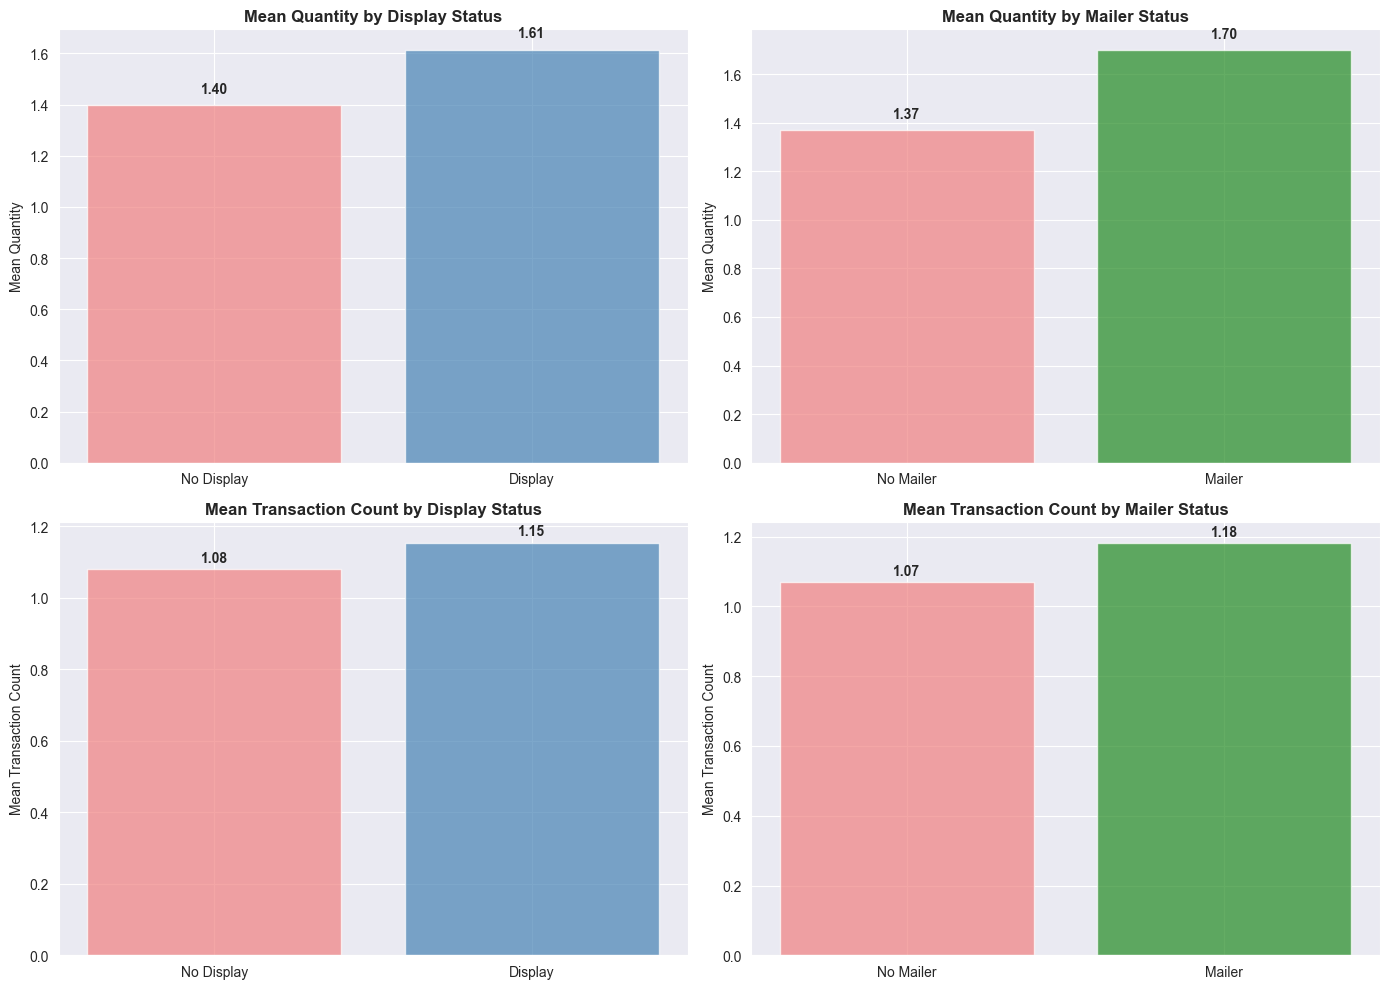

QUANTITY & TRANSACTION COUNT BY EXPOSURE STATUS

Display effect on Quantity:
  No display: 1.40
  With display: 1.61
  Difference: 0.22 (+15.5%)

Mailer effect on Quantity:
  No mailer: 1.37
  With mailer: 1.70
  Difference: 0.33 (+23.9%)

Display effect on Transaction Count:
  No display: 1.08
  With display: 1.15
  Difference: 0.07 (+6.9%)

Mailer effect on Transaction Count:
  No mailer: 1.07
  With mailer: 1.18
  Difference: 0.11 (+10.5%)


In [50]:
# Compare quantity and transaction count by exposure status
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Quantity by display status
display_qty = exposure_sales.groupby('has_display')['total_quantity'].mean()
axes[0, 0].bar(['No Display', 'Display'], display_qty.values, color=['lightcoral', 'steelblue'], alpha=0.7)
axes[0, 0].set_ylabel('Mean Quantity')
axes[0, 0].set_title('Mean Quantity by Display Status', fontsize=12, fontweight='bold')
for i, v in enumerate(display_qty.values):
    axes[0, 0].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# 2) Quantity by mailer status
mailer_qty = exposure_sales.groupby('has_mailer')['total_quantity'].mean()
axes[0, 1].bar(['No Mailer', 'Mailer'], mailer_qty.values, color=['lightcoral', 'forestgreen'], alpha=0.7)
axes[0, 1].set_ylabel('Mean Quantity')
axes[0, 1].set_title('Mean Quantity by Mailer Status', fontsize=12, fontweight='bold')
for i, v in enumerate(mailer_qty.values):
    axes[0, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# 3) Transaction count by display status
display_txn = exposure_sales.groupby('has_display')['n_transactions'].mean()
axes[1, 0].bar(['No Display', 'Display'], display_txn.values, color=['lightcoral', 'steelblue'], alpha=0.7)
axes[1, 0].set_ylabel('Mean Transaction Count')
axes[1, 0].set_title('Mean Transaction Count by Display Status', fontsize=12, fontweight='bold')
for i, v in enumerate(display_txn.values):
    axes[1, 0].text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

# 4) Transaction count by mailer status
mailer_txn = exposure_sales.groupby('has_mailer')['n_transactions'].mean()
axes[1, 1].bar(['No Mailer', 'Mailer'], mailer_txn.values, color=['lightcoral', 'forestgreen'], alpha=0.7)
axes[1, 1].set_ylabel('Mean Transaction Count')
axes[1, 1].set_title('Mean Transaction Count by Mailer Status', fontsize=12, fontweight='bold')
for i, v in enumerate(mailer_txn.values):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary stats
print("="*60)
print("QUANTITY & TRANSACTION COUNT BY EXPOSURE STATUS")
print("="*60)
print(f"\nDisplay effect on Quantity:")
print(f"  No display: {display_qty[0]:.2f}")
print(f"  With display: {display_qty[1]:.2f}")
print(f"  Difference: {display_qty[1] - display_qty[0]:.2f} (+{(display_qty[1]/display_qty[0]-1)*100:.1f}%)")

print(f"\nMailer effect on Quantity:")
print(f"  No mailer: {mailer_qty[0]:.2f}")
print(f"  With mailer: {mailer_qty[1]:.2f}")
print(f"  Difference: {mailer_qty[1] - mailer_qty[0]:.2f} (+{(mailer_qty[1]/mailer_qty[0]-1)*100:.1f}%)")

print(f"\nDisplay effect on Transaction Count:")
print(f"  No display: {display_txn[0]:.2f}")
print(f"  With display: {display_txn[1]:.2f}")
print(f"  Difference: {display_txn[1] - display_txn[0]:.2f} (+{(display_txn[1]/display_txn[0]-1)*100:.1f}%)")

print(f"\nMailer effect on Transaction Count:")
print(f"  No mailer: {mailer_txn[0]:.2f}")
print(f"  With mailer: {mailer_txn[1]:.2f}")
print(f"  Difference: {mailer_txn[1] - mailer_txn[0]:.2f} (+{(mailer_txn[1]/mailer_txn[0]-1)*100:.1f}%)")

## 5.6 Combined Effects (Display × Mailer)

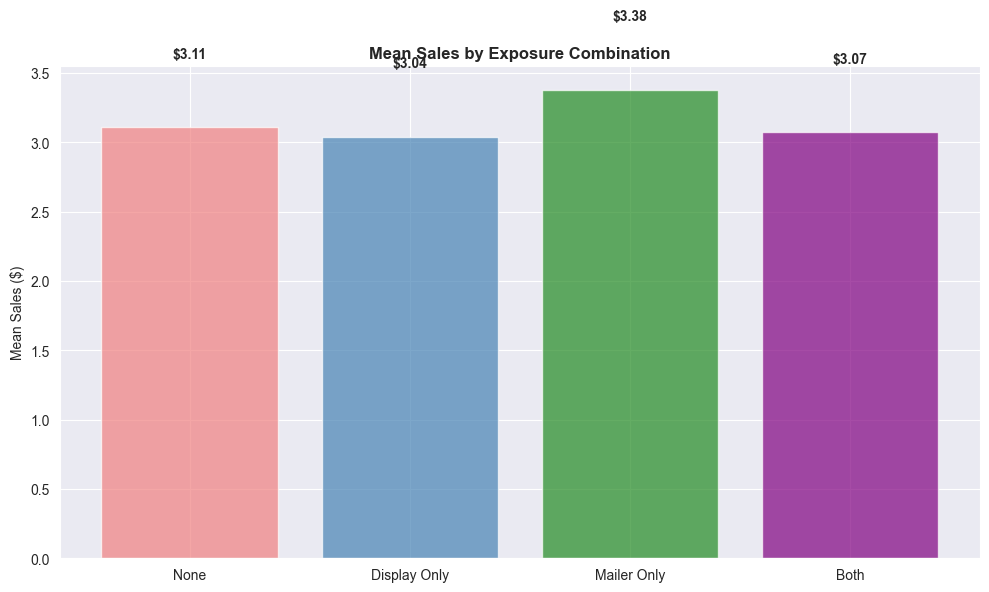

COMBINED EXPOSURE EFFECTS
| exposure_group   |   mean_sales |   median_sales |        n_records |
|:-----------------|-------------:|---------------:|-----------------:|
| None             |      3.10767 |           2.31 |      1.87781e+06 |
| Display Only     |      3.04216 |           2    | 133130           |
| Mailer Only      |      3.38117 |           2.2  | 246882           |
| Both             |      3.07337 |           2    | 103919           |

Lift relative to 'None':
  Display Only: +-2.1%
  Mailer Only: +8.8%
  Both: +-1.1%


In [51]:
# Create 4 groups: (no display, no mailer), (display only), (mailer only), (both)
exposure_sales = exposure_sales.assign(
    exposure_group=lambda x: np.where(
        (x['has_display'] == 0) & (x['has_mailer'] == 0), 'None',
        np.where(
            (x['has_display'] == 1) & (x['has_mailer'] == 0), 'Display Only',
            np.where(
                (x['has_display'] == 0) & (x['has_mailer'] == 1), 'Mailer Only',
                'Both'
            )
        )
    )
)

# Group statistics
combined_stats = exposure_sales.groupby('exposure_group').agg(**{
    'mean_sales': ('total_sales', 'mean'),
    'median_sales': ('total_sales', 'median'),
    'n_records': ('total_sales', 'count')
})

# Reorder groups
group_order = ['None', 'Display Only', 'Mailer Only', 'Both']
combined_stats = combined_stats.reindex(group_order)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['lightcoral', 'steelblue', 'forestgreen', 'purple']
bars = ax.bar(combined_stats.index, combined_stats['mean_sales'], color=colors, alpha=0.7)
ax.set_ylabel('Mean Sales ($)')
ax.set_title('Mean Sales by Exposure Combination', fontsize=12, fontweight='bold')

# Add value labels
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'${bar.get_height():.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("="*60)
print("COMBINED EXPOSURE EFFECTS")
print("="*60)
print(combined_stats.to_markdown())

# Calculate lift relative to no exposure
baseline = combined_stats.loc['None', 'mean_sales']
print(f"\nLift relative to 'None':")
for group in group_order[1:]:
    lift = (combined_stats.loc[group, 'mean_sales'] / baseline - 1) * 100
    print(f"  {group}: +{lift:.1f}%")

## Key Takeaways

**Data Characteristics:**
- `causal_data`: Records product-store-weeks WITH marketing exposure only
- ~80% of transactions have no matching exposure record (true control group)
- Excluded outlier departments: KIOSK-GAS, MISC SALES TRAN (abnormal quantities)

**Exposure Distribution:**
- ~43% of causal_data records have display exposure
- ~69% have mailer exposure
- Exposure rates vary significantly by department and brand

**Exposure-Sales Relationship (Descriptive):**

| Metric | Display Lift | Mailer Lift |
|--------|-------------|-------------|
| Sales ($) | -2.6% | +6.1% |
| Quantity | +15.5% | +24.0% |
| Transaction Count | +6.9% | +10.5% |

- Display: Higher quantity/transactions but lower sales → likely used for low-price promotions
- Mailer: Positive lift across all metrics
- Combined (Display + Mailer): Highest overall performance

**Important Limitations:**
- This is **observational data** → correlation, not causation
- Selection bias: High-selling products may receive more marketing support
- For causal inference, see econometric analysis (PSM, DID, etc.) in TODO.md